In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

# **Importing the required modules**

In [2]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob 

import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

import torch

#check if there is gpu available
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# **Installing Ultralytics and ipywidgets**
 Ultralytics for importing Yolo and ipywidgets for HTML widgets for Jupyter notebooks and the IPython kernel.

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.3/872.3 kB 24.4 MB/s eta 0:00:0000:01


In [4]:
!pip install -U ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 

****

# **Load the dataset**

In [5]:
data_path = '/kaggle/input/car-plate-detection'



# **Defining dictionary**
Defining dictionary for saving the measurements and path for the files

In [6]:
label_dict = dict(
                img_path = [],
                xmin = [],
                xmax = [],
                ymin = [],
                ymax = [],
                imgw = [],
                imgh = []
)

In [7]:
label_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'imgw': [],
 'imgh': []}

# **Get XML files**

In [8]:
import os
from glob import glob

# Get a list of XML files in the specified directory
xml_files = glob(f'{data_path}/annotations/*.xml')

# Print the list of XML files
print(xml_files)

['/kaggle/input/car-plate-detection/annotations/Cars339.xml', '/kaggle/input/car-plate-detection/annotations/Cars13.xml', '/kaggle/input/car-plate-detection/annotations/Cars74.xml', '/kaggle/input/car-plate-detection/annotations/Cars16.xml', '/kaggle/input/car-plate-detection/annotations/Cars291.xml', '/kaggle/input/car-plate-detection/annotations/Cars236.xml', '/kaggle/input/car-plate-detection/annotations/Cars429.xml', '/kaggle/input/car-plate-detection/annotations/Cars132.xml', '/kaggle/input/car-plate-detection/annotations/Cars251.xml', '/kaggle/input/car-plate-detection/annotations/Cars51.xml', '/kaggle/input/car-plate-detection/annotations/Cars165.xml', '/kaggle/input/car-plate-detection/annotations/Cars313.xml', '/kaggle/input/car-plate-detection/annotations/Cars240.xml', '/kaggle/input/car-plate-detection/annotations/Cars201.xml', '/kaggle/input/car-plate-detection/annotations/Cars412.xml', '/kaggle/input/car-plate-detection/annotations/Cars227.xml', '/kaggle/input/car-plate-de

In [9]:
import re

def num_in_string(file):
    
    match = re.search(r'(\d+)' , file)
    
    if match:
        return int(match.group(0))
    else:
        return 0

#check if the defined functions works fine or not
print(num_in_string("www321.txt"))

321


In [10]:
# Import necessary libraries for XML parsing and image processing
import xml.etree.ElementTree as xet
import cv2


# Iterate through sorted XML files
# Function to sort XML files based on a numerical value within the filename
for filename in sorted(xml_files, key=num_in_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element
    member_obj = root.find('object')

    # Find the 'bndbox' element containing bounding box coordinates
    labels_info = member_obj.find('bndbox')

    # Extract bounding box coordinates
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and path
    img_name = root.find('filename').text
    img_path = os.path.join(data_path, 'images', img_name)

    # Read the image and get its dimensions
    height, width, _ = cv2.imread(img_path).shape

    # Append extracted information to the dictionary
    label_dict['img_path'].append(img_path)
    label_dict['xmin'].append(xmin)
    label_dict['xmax'].append(xmax)
    label_dict['ymin'].append(ymin)
    label_dict['ymax'].append(ymax)
    label_dict['imgh'].append(height)
    label_dict['imgw'].append(width)

In [11]:
import pandas as pd

# Import the dictionary containing the labels into a Pandas DataFrame
all_data = pd.DataFrame(label_dict)

# Display the DataFrame
print(all_data)

                                              img_path  xmin  xmax  ymin  \
0    /kaggle/input/car-plate-detection/images/Cars0...   226   419   125   
1    /kaggle/input/car-plate-detection/images/Cars1...   134   262   128   
2    /kaggle/input/car-plate-detection/images/Cars2...   229   270   176   
3    /kaggle/input/car-plate-detection/images/Cars3...   142   261   128   
4    /kaggle/input/car-plate-detection/images/Cars4...   156   503    82   
..                                                 ...   ...   ...   ...   
428  /kaggle/input/car-plate-detection/images/Cars4...   142   258   128   
429  /kaggle/input/car-plate-detection/images/Cars4...    86   208   166   
430  /kaggle/input/car-plate-detection/images/Cars4...    38   116   159   
431  /kaggle/input/car-plate-detection/images/Cars4...    55   343    82   
432  /kaggle/input/car-plate-detection/images/Cars4...    95   196   258   

     ymax  imgw  imgh  
0     173   500   268  
1     160   400   248  
2     193   400

# **Splitting the dataset**

In [12]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train, test = train_test_split(all_data, test_size=0.1, random_state=42)

# Further split the training set into training and validation sets
train, val = train_test_split(train, train_size=8/9, random_state=42)

In [13]:
print(f'''

len(train) = {len(train)},
len(test) = {len(test)},
len(val) = {len(val)} ''')



len(train) = 345,
len(test) = 44,
len(val) = 44 


In [14]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

# **Converting the data in the Yolo Format**

In [15]:
def make_yolo_format_folder(split_name, split_df):
    """
    Creates YOLO format folders for images and labels based on a given DataFrame.

    Args:
        split_name (str): The name of the split (e.g., "train", "val").
        split_df (pandas.DataFrame): A DataFrame containing image paths, bounding box coordinates, and image dimensions.
    """

    # Create directories for labels and images
    labels_path = os.path.join("datasets", "cars_plate_detect_new", split_name, "labels")
    images_path = os.path.join("datasets", "cars_plate_detect_new", split_name, "images")
    os.makedirs(labels_path)
    os.makedirs(images_path)

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        # Extract image name and extension
        img_name, img_extension = os.path.splitext(os.path.basename(row["img_path"]))

        # Calculate bounding box center and dimensions in YOLO format
        x_center = (row["xmin"] + row["xmax"]) / 2 / row["imgw"]
        y_center = (row["ymin"] + row["ymax"]) / 2 / row["imgh"]
        width = (row["xmax"] - row["xmin"]) / row["imgw"]
        height = (row["ymax"] - row["ymin"]) / row["imgh"]

        # Create label file and write YOLO format annotation
        label_path = os.path.join(labels_path, f"{img_name}.txt")
        with open(label_path, "w") as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy image to the images directory
        shutil.copy(row["img_path"], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [16]:
# os.path.splitext(os.path.basename('/kaggle/input/car-plate-detection/images/Cars4...txt'))

In [17]:
make_yolo_format_folder("train" , train)
make_yolo_format_folder("val" , val)
make_yolo_format_folder("test" , test)

Created 'datasets/cars_plate_detect_new/train/images' and 'datasets/cars_plate_detect_new/train/labels'
Created 'datasets/cars_plate_detect_new/val/images' and 'datasets/cars_plate_detect_new/val/labels'
Created 'datasets/cars_plate_detect_new/test/images' and 'datasets/cars_plate_detect_new/test/labels'


In [18]:
os.getcwd()

'/kaggle/working'

# **Creating a YAML file**

In [19]:
# Create a YAML string representing the dataset configuration
datasets_yaml = """
path: cars_plate_detect_new

train: train/images
val: val/images
test: test/images

nc: 1
names: ['license_plate']
"""

# Write the YAML string to a file named "datasets.yaml"
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# **Loading and Training of Model**

In [20]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 148MB/s]


In [21]:
#Train the model
model.train(
    data = 'datasets.yaml',
    epochs = 100,
    device = 'cuda',
    batch = 16,
    imgsz = 320,
    cache = True)

Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 38.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/working/datasets/cars_plate_detect_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 475.48it/s]


train: New cache created: /kaggle/working/datasets/cars_plate_detect_new/train/labels.cache


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 199.30it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_plate_detect_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 480.84it/s]

val: New cache created: /kaggle/working/datasets/cars_plate_detect_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 205.11it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.749G      1.782      2.964      1.361         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         44         44    0.00397      0.932      0.457      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       0.7G      1.572      1.523      1.117         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

                   all         44         44      0.821      0.341       0.45      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.696G      1.515      1.407      1.163         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         44         44      0.701      0.295      0.499      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.703G      1.522      1.341      1.174         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44      0.491      0.341      0.376      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.703G      1.512      1.242      1.194         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


                   all         44         44      0.405      0.318      0.317      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.703G      1.533      1.278      1.164         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]


                   all         44         44      0.341      0.545      0.332      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.703G       1.52       1.22      1.198         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         44         44      0.964      0.613      0.793      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.703G      1.419      1.117      1.164         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44      0.717      0.691      0.736      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.703G       1.44      1.064      1.157         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]

                   all         44         44      0.801      0.795      0.831      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.703G      1.362     0.9993      1.136         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

                   all         44         44      0.849      0.795      0.823      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.703G      1.358     0.9719      1.144         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.843      0.818      0.854      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.703G      1.307      0.939      1.105         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44      0.839      0.864      0.877      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.703G      1.378     0.9285      1.092         23        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         44         44      0.854      0.886      0.879      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.703G      1.272     0.9023      1.074         26        320: 100%|██████████| 22/22 [00:02<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]

                   all         44         44      0.948      0.864      0.928      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       0.7G      1.298     0.8759      1.105         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


                   all         44         44      0.883      0.864      0.919      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.703G      1.336      0.884      1.099         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]

                   all         44         44      0.884      0.909      0.886        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.703G      1.315     0.8742       1.11         26        320: 100%|██████████| 22/22 [00:02<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         44         44      0.918      0.886      0.921       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.703G      1.284     0.8457       1.09         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.888      0.899      0.904      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.703G      1.249     0.8229      1.077         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         44         44      0.939      0.841       0.93      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.703G      1.231     0.7841      1.043         25        320: 100%|██████████| 22/22 [00:02<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         44         44      0.927      0.909      0.934      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.703G      1.215     0.8013      1.057         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.928      0.909      0.903      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.703G      1.196     0.7956      1.069         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


                   all         44         44      0.965      0.841      0.912       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.703G      1.174     0.7712      1.031         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.847      0.886      0.906      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.703G      1.202     0.7601      1.043         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.924      0.886      0.876      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.703G      1.192     0.7624       1.05         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         44         44      0.939      0.886       0.92      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.703G      1.179     0.7425      1.072         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]

                   all         44         44      0.886      0.886      0.904      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       0.7G      1.157     0.7294      1.059         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.911      0.931      0.933      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.703G       1.22     0.7465      1.019         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


                   all         44         44      0.905      0.863      0.925      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.703G      1.148     0.7156      1.029         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         44         44      0.903      0.846      0.927      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.703G      1.117     0.7011      1.037         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

                   all         44         44       0.94      0.841      0.931      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.703G      1.142     0.6996      1.039         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.917      0.818      0.911      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.703G      1.119     0.7188       1.02         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]


                   all         44         44      0.939      0.818      0.898      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.703G      1.124     0.7137      1.031         25        320: 100%|██████████| 22/22 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.966      0.864      0.891      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.703G      1.089     0.6827      1.004         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.924      0.824      0.914      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.703G       1.04     0.6665     0.9995         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44       0.85      0.841        0.9      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.703G      1.086     0.6648      1.019         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.837      0.909      0.929      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.703G      1.093     0.6784      1.019         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]

                   all         44         44      0.952      0.818       0.91      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.705G      1.093     0.6667      1.011         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

                   all         44         44      0.923      0.841       0.92      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       0.7G      1.041      0.675      1.003         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         44         44      0.979      0.795      0.915      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.703G      1.047      0.652      1.003         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         44         44      0.918      0.795      0.875      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.703G      1.064     0.6663     0.9979         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         44         44      0.914      0.773      0.881      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.703G      1.054     0.6576      1.006         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.935      0.818      0.893      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.703G      1.025     0.6362     0.9984         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


                   all         44         44      0.878      0.864      0.913       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.703G       1.04     0.6428     0.9953         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]

                   all         44         44      0.923      0.841       0.87      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.703G      1.008     0.6269     0.9781         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


                   all         44         44      0.942      0.818      0.865      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       0.7G      1.048     0.6156     0.9937         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]

                   all         44         44      0.851      0.912      0.934      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       0.7G       1.03     0.6509     0.9872         11        320: 100%|██████████| 22/22 [00:02<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         44         44      0.919      0.841      0.879      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.703G     0.9898     0.5914     0.9715         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]

                   all         44         44      0.902      0.833      0.889      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.703G     0.9848     0.6034      0.983         24        320: 100%|██████████| 22/22 [00:02<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]

                   all         44         44      0.914      0.841      0.909      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.703G     0.9415     0.5698     0.9717         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.927      0.863      0.915      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.703G     0.9939     0.5975     0.9709         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


                   all         44         44      0.865      0.886      0.907      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.703G     0.9053     0.5666     0.9543         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


                   all         44         44       0.94      0.841      0.907      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.703G     0.9338     0.5699     0.9442         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


                   all         44         44      0.914      0.818      0.901      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.703G     0.9147     0.5688     0.9783         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44      0.957      0.818      0.929      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       0.7G     0.9685     0.5757     0.9781         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         44         44      0.968      0.818      0.923      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.703G     0.9213     0.5553     0.9536         11        320: 100%|██████████| 22/22 [00:02<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


                   all         44         44       0.98      0.818      0.894       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       0.7G     0.9352     0.5558     0.9617         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


                   all         44         44      0.973      0.834      0.891      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.703G     0.9208     0.5647      0.949         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.918      0.795      0.887      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.703G      0.918      0.557     0.9531         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.919      0.818      0.892      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.703G     0.9032     0.5545     0.9531         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         44         44      0.923      0.886      0.953      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.703G     0.8753     0.5354     0.9418         25        320: 100%|██████████| 22/22 [00:02<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


                   all         44         44      0.852      0.916      0.921      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       0.7G      0.865     0.5389     0.9484         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.902      0.841       0.91      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       0.7G     0.8957     0.5603     0.9587         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


                   all         44         44      0.876      0.841      0.893      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.703G     0.8669     0.5278     0.9568         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         44         44      0.907      0.882      0.882      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.703G     0.8762     0.5236     0.9527         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44        0.9      0.864      0.892      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.703G      0.856     0.5148     0.9406         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.944      0.864      0.898      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       0.7G     0.8358     0.5208     0.9375         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         44         44      0.949      0.839      0.902        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.703G     0.8489     0.5056     0.9368         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.884      0.862      0.901      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.703G      0.864      0.526     0.9522         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.24it/s]

                   all         44         44      0.866       0.88      0.896      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.703G     0.8796     0.5361     0.9518         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]

                   all         44         44       0.89      0.841      0.887      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.703G     0.8871     0.5289     0.9314         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


                   all         44         44      0.863      0.886      0.887      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.703G     0.8294     0.5213     0.9379         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

                   all         44         44      0.862      0.886      0.887      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.703G     0.8566     0.5199     0.9364         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.866      0.882      0.871      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.703G     0.8356     0.4983     0.9359         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.863       0.86      0.875      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.703G     0.8325     0.4971     0.9344         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]

                   all         44         44        0.9      0.816      0.886      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.703G     0.8083     0.4876     0.9135         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]

                   all         44         44      0.886      0.881      0.892      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.703G     0.8405      0.498     0.9383         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


                   all         44         44      0.889      0.909      0.909      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.703G     0.8077     0.4736     0.9314         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

                   all         44         44      0.871       0.92      0.918      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.703G     0.8007     0.4911     0.9186         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44      0.831      0.932      0.914      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.703G     0.7884     0.4788      0.926         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]

                   all         44         44      0.899      0.818      0.888      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.703G     0.7957     0.4725     0.9334         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


                   all         44         44      0.902      0.864      0.917      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.703G     0.7839     0.4763     0.9302         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]

                   all         44         44      0.897      0.841       0.91      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.703G     0.7777     0.4727     0.9135         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


                   all         44         44      0.925      0.864      0.934      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.703G     0.7823     0.4848     0.9292         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


                   all         44         44      0.907      0.883      0.914      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       0.7G     0.7786      0.482     0.9116         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


                   all         44         44      0.922      0.864      0.915      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.703G      0.753     0.4595     0.9173         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]

                   all         44         44      0.949       0.84      0.923      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.703G     0.7061     0.4416     0.8924         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

                   all         44         44      0.872      0.932       0.93      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       0.7G     0.7755     0.4668     0.9224         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]

                   all         44         44      0.873      0.932       0.92       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.703G     0.7434     0.4547     0.9176         25        320: 100%|██████████| 22/22 [00:02<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]


                   all         44         44       0.91      0.922      0.918       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.703G     0.7512     0.4685     0.9179         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]

                   all         44         44      0.867      0.932      0.916      0.552


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       0.7G       1.01     0.5512      1.017          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]

                   all         44         44      0.869      0.904      0.912      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       0.7G      1.027     0.5194      1.035          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]

                   all         44         44      0.895      0.841      0.904      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       0.7G     0.9969     0.5172      1.029          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         44         44      0.916      0.841      0.901      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       0.7G     0.9937     0.5184      1.012          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]

                   all         44         44       0.92      0.841      0.901      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       0.7G     0.9346     0.5044     0.9829          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]

                   all         44         44      0.924      0.831      0.905      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       0.7G     0.9502     0.4976      0.981          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         44         44      0.918      0.841      0.902      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       0.7G     0.9415     0.4908     0.9873          9        320: 100%|██████████| 22/22 [00:02<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]

                   all         44         44      0.877      0.864       0.89      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       0.7G     0.9564     0.4835      1.005          8        320: 100%|██████████| 22/22 [00:02<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.52it/s]

                   all         44         44      0.891      0.864      0.894      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       0.7G      0.918     0.4827     0.9972          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

                   all         44         44      0.898      0.864       0.91      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       0.7G      0.902     0.4801     0.9776          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]

                   all         44         44      0.904      0.859      0.913       0.53



100 epochs completed in 0.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


                   all         44         44      0.867      0.932      0.916      0.552
Speed: 0.0ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▂▃▁▆▇▇▇█████████▇▇███████▇██▇▇████████▇█
metrics/mAP50-95(B),▃▃▁▅▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇████████
metrics/precision(B),▁▆▃▆▇▇▇▇█▇▇▇██▇███▇█▇███▇▇█▇▇▇▇▇▇▇▇█▇█▇▇
metrics/recall(B),█▁▄▅▇▇███▇▇▇▇▇█▆▆▇█▇▇▇▇▇█▇▇▇▇▇██▇▇██▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▃▃▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7823e9e36980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# **Results of Training run directory**

In [22]:
# Find the latest training run directory based on the numerical part of the name
log_dir = max(glob('runs/detect/train*'), key=num_in_string)

# Read the results CSV file from the latest training run directory
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))

# Print the results DataFrame
print(results)

                   epoch        train/box_loss        train/cls_loss  \
0                      1               1.78190               2.96380   
1                      2               1.57170               1.52350   
2                      3               1.51490               1.40700   
3                      4               1.52170               1.34120   
4                      5               1.51160               1.24240   
..                   ...                   ...                   ...   
95                    96               0.95024               0.49760   
96                    97               0.94152               0.49076   
97                    98               0.95640               0.48349   
98                    99               0.91799               0.48266   
99                   100               0.90203               0.48010   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                1.36080               0.00397               0.

In [23]:
results.columns = results.columns.str.strip()

# Create a new index representing epochs, starting from 1
epochs = results.index + 1

# Print the epochs
print(epochs)

RangeIndex(start=1, stop=101, step=1)


In [24]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

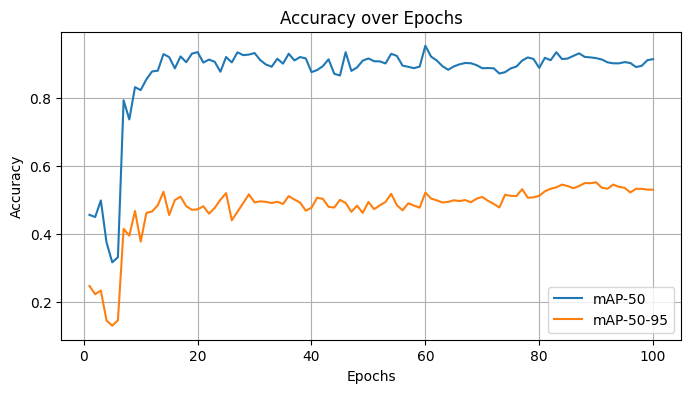

In [25]:
# Import matplotlib library for plotting
import matplotlib.pyplot as plt

# Extract mAP-50 and mAP-50-95 values from 'results' dictionary (assuming this dictionary contains metric values)
map_0_5 = results['metrics/mAP50(B)']
map_0_5_0_95 = results['metrics/mAP50-95(B)']


plt.figure(figsize = (8,4))
plt.plot(epochs , map_0_5 , label = 'mAP-50')
plt.plot(epochs , map_0_5_0_95 , label = 'mAP-50-95')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# **Saving the Model**

In [26]:
model.save('Number_Plate_Detection_model(Yolov8).pt' )

In [27]:
results = model.predict('/kaggle/input/car-plate-detection/images/Cars102.png')
results


image 1/1 /kaggle/input/car-plate-detection/images/Cars102.png: 256x320 1 license_plate, 39.1ms
Speed: 0.9ms preprocess, 39.1ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'license_plate'}
 obb: None
 orig_img: array([[[47, 44, 30],
         [46, 43, 29],
         [46, 45, 31],
         ...,
         [30, 36, 31],
         [28, 34, 29],
         [27, 33, 28]],
 
        [[47, 44, 30],
         [46, 42, 31],
         [46, 45, 31],
         ...,
         [28, 34, 29],
         [27, 33, 28],
         [27, 33, 28]],
 
        [[45, 43, 32],
         [44, 42, 32],
         [47, 45, 34],
         ...,
         [28, 34, 29],
         [28, 34, 29],
         [27, 33, 28]],
 
        ...,
 
        [[ 9, 14, 12],
         [ 9, 14, 12],
         [ 8, 15, 12],
         ...,
         [ 3, 32,  6],
         [ 2, 31,  6],
         [ 1, 30,  5]],
 
        [[ 8, 13, 11],
         [ 8, 13, 11],
         [ 7, 13, 12],
         ...,
         [ 8, 37, 12],
         [ 7, 35, 12],
         [ 5, 30,  8]],
 
        [[ 7, 12, 10

In [28]:
# Import necessary libraries
import cv2

# Load the image
img1 = cv2.imread('/kaggle/input/car-plate-detection/images/Cars429.png')

# Make predictions using the model
results = model.predict('/kaggle/input/car-plate-detection/images/Cars429.png')

# Convert the image from BGR to RGB format (if needed for visualization or further processing)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


image 1/1 /kaggle/input/car-plate-detection/images/Cars429.png: 320x256 1 license_plate, 37.6ms
Speed: 0.9ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 256)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9166], device='cuda:0')
data: tensor([[ 86.7877, 166.6591, 205.9672, 193.4485,   0.9166,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (400, 301)
shape: torch.Size([1, 6])
xywh: tensor([[146.3774, 180.0538, 119.1796,  26.7893]], device='cuda:0')
xywhn: tensor([[0.4863, 0.4501, 0.3959, 0.0670]], device='cuda:0')
xyxy: tensor([[ 86.7877, 166.6591, 205.9672, 193.4485]], device='cuda:0')
xyxyn: tensor([[0.2883, 0.4166, 0.6843, 0.4836]], device='cuda:0')


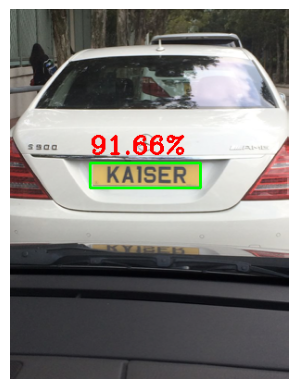

In [29]:
for result in results:
    for box in result.boxes:
        print(box)
        x1,y1,x2,y2 = map(int , box.xyxy[0])
        confidence = box.conf[0]
        
        cv2.rectangle(img1 , (x1,y1) , (x2,y2) , (0,255,0) , 2)
        cv2.putText(img1 , f'{confidence*100 :.2f}%' , (x1,y1-10),
                   cv2.FONT_HERSHEY_COMPLEX, 0.9 , (255,0,0) , 2)
plt.imshow(img1)
plt.axis('off')
plt.show()


# **Make Predictions**

In [31]:
import pytesseract
from pytesseract import Output  # Import for potential future text extraction

def model_prediction(image_path):
    """
    This function performs object detection on the provided image,
    extracts bounding boxes with confidence scores, and attempts to read text
    from the detected license plate regions.

    Args:
        image_path (str): Path to the image file.
    """

    # Read the image in BGR color format (OpenCV standard)
    img = cv2.imread(image_path)
    results = model.predict(image_path)
    # Convert the image to RGB format (required by pytesseract)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate over each prediction result (assuming you have a model)
    for result in results:
        for box in result.boxes: # Assuming results are available
        # Extract integer coordinates from the bounding box data
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Get the confidence score for the detection
            confidence = box.conf[0]

            # Draw a green rectangle around the detected object
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put text with the confidence score on top of the rectangle
            cv2.putText(img, f'{confidence * 100 :.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_COMPLEX, 0.9, (255, 0, 0), 2)

            # Extract the region of interest (ROI) for potential license plate text
            roi = img[y1:y2, x1:x2]
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f'Detected plate number: {text}')

    # Display the processed image with bounding boxes and text
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    


image 1/1 /kaggle/input/car-plate-detection/images/Cars101.png: 256x320 1 license_plate, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)
Detected plate number: HR 26 BC 5514



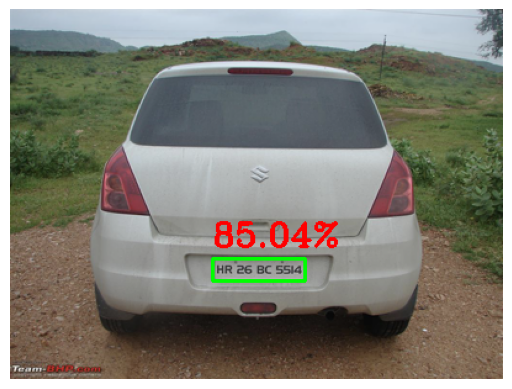


image 1/1 /kaggle/input/car-plate-detection/images/Cars109.png: 224x320 1 license_plate, 36.8ms
Speed: 0.9ms preprocess, 36.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
Detected plate number: 4 CZI7 KOD



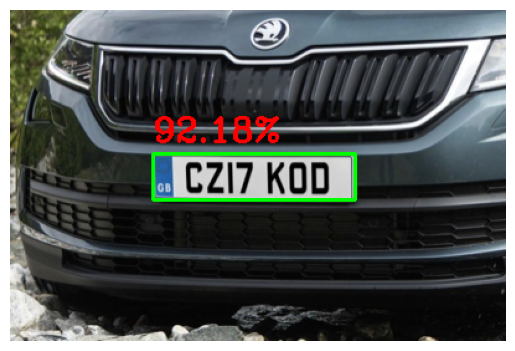


image 1/1 /kaggle/input/car-plate-detection/images/Cars124.png: 224x320 3 license_plates, 7.5ms
Speed: 0.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 320)
Detected plate number: ‘dcke

Detected plate number: om

Detected plate number: 


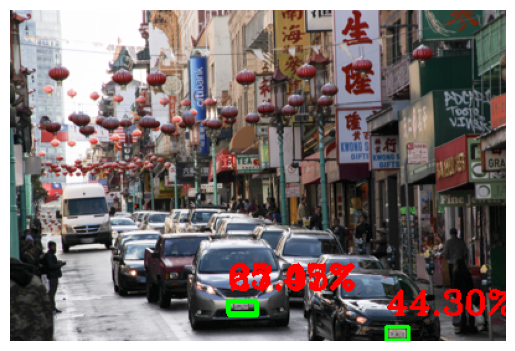


image 1/1 /kaggle/input/car-plate-detection/images/Cars149.png: 256x320 1 license_plate, 8.2ms
Speed: 0.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)
Detected plate number: 716263



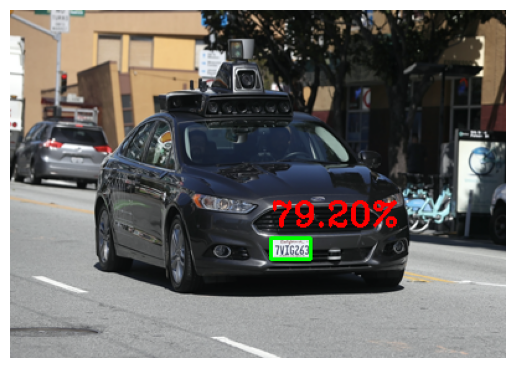

In [33]:
images = ['/kaggle/input/car-plate-detection/images/Cars101.png','/kaggle/input/car-plate-detection/images/Cars109.png', '/kaggle/input/car-plate-detection/images/Cars124.png' ,'/kaggle/input/car-plate-detection/images/Cars149.png']

for image in images:
    model_prediction(image)

# **Manual way to predict the image**

In [ ]:
# import os
# import cv2
# import matplotlib.pyplot as plt

# # Directory paths
# image_dir = '/kaggle/working/datasets/cars_plate_detect_new/train/images'
# label_dir = '/kaggle/working/datasets/cars_plate_detect_new/train/labels'

# # Get the first image file
# image_files = sorted(os.listdir(image_dir))
# first_image_file = image_files[0]

# # Construct paths for the image and its corresponding label
# image_path = os.path.join(image_dir, first_image_file)
# label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# # Load the image using OpenCV
# image = cv2.imread(image_path)
# # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Read the label file to get bounding box information
# with open(label_path, 'r') as f:
#     lines = f.readlines()

# # Plot the bounding box on the image
# for line in lines:
#     # Parse the label file line to extract bounding box information
#     class_id, x_center, y_center, width, height = map(float, line.strip().split())
#     img_height, img_width, _ = image.shape

#     # Convert YOLO format to bounding box format
#     x_center *= img_width
#     y_center *= img_height
#     width *= img_width
#     height *= img_height

#     # Calculate the top-left and bottom-right coordinates of the bounding box
#     x1 = int(x_center - width / 2)
#     y1 = int(y_center - height / 2)
#     x2 = int(x_center + width / 2)
#     y2 = int(y_center + height / 2)

#     # Draw the bounding box on the image using a green rectangle
#     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# # Display the image with bounding box using matplotlib
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()  # Display the image